In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
os.listdir('./data')

['rsc15_train_tr.txt', 'train_500000.csv']

In [2]:
train = pd.read_csv('./data/rsc15_train_tr.txt',sep='\t', dtype={'ItemId':np.int64})

In [3]:
train.shape

(31579006, 3)

데이터 크기 실화? 일단 좀 줄여야겠다

In [10]:
#train = train.head(500000)
#train.to_csv('./data/train_500000.csv', index = False)

In [107]:
train = pd.read_csv('./data/train_500000.csv', dtype={'ItemId':np.int64})
train.head()

,SessionId,ItemId,Time
0,1,214536502,1.396868e+09
1,1,214536500,1.396868e+09
2,1,214536506,1.396868e+09
3,1,214577561,1.396868e+09
4,2,214662742,1.396879e+09


In [ ]:
if __name__ == '__main__':
    # load RSC15 preprocessed train dataframe
    PATH_TO_TRAIN = './data/train.csv'
    train_data = pd.read_csv(PATH_TO_TRAIN, sep='\t', dtype={'ItemId':np.int64})

    new_df = preprocess_df(train_data)
    dts = compute_dwell_time(new_df)

    #get_statistics(dts)

    join_dwell_reps(new_df, dts, threshold=200000)

    # Now, we augment the sessions copying each entry an additional (dwellReps[i]-1) times
    df_aug = augment(new_df)
    df_aug.to_csv("./data/augmented_train.csv", index=False, sep='\t')

# preprocess_df

In [33]:
def preprocess_df(df):    
    n_items = len(train['ItemId'].unique())
    aux = list(train['ItemId'].unique())
    itemids = np.array(aux)
    itemidmap = pd.Series(data=np.arange(n_items), index=itemids)  # (id_item => (0, n_items))
    
    item_key = 'ItemId'
    session_key = 'SessionId'
    time_key = 'Time'
    
    data = pd.merge(df, pd.DataFrame({item_key:itemids, 'ItemIdx':itemidmap[itemids].values}), on=item_key, how='inner')
    data.sort_values([session_key, time_key], inplace=True)

    length = len(data['ItemId'])
        
    return data

In [18]:
n_items = len(train['ItemId'].unique())
itemids = list(train['ItemId'].unique())

In [22]:
itemidmap = pd.Series(data = np.arange(n_items), index = itemids) #item별로 넘버링
itemidmap.head()

214536502    0
214536500    1
214536506    2
214577561    3
214662742    4
dtype: int32

In [23]:
item_key = 'ItemId'
session_key = 'SessionId'
time_key = 'Time'

In [25]:
pd.DataFrame({item_key:itemids, 'ItemIdx':itemidmap[itemids].values}).head()# itemidmap을 데이터프레임화

,ItemId,ItemIdx
0,214536502,0
1,214536500,1
2,214536506,2
3,214577561,3
4,214662742,4


In [26]:
data = pd.merge(train, pd.DataFrame({item_key:itemids, 'ItemIdx':itemidmap[itemids].values}), on=item_key, how='inner')

In [27]:
data.head()

,SessionId,ItemId,Time,ItemIdx
0,1,214536502,1.396868e+09,0
1,561,214536502,1.396427e+09,0
2,877,214536502,1.396901e+09,0
3,1343,214536502,1.396865e+09,0
4,3168,214536502,1.396350e+09,0


In [30]:
data.sort_values([session_key, time_key], inplace = True) #세션별 시간 순으로 정렬

In [108]:
new_df = preprocess_df(train)

In [35]:
new_df.head() #세션별 시간 순으로 정렬

,SessionId,ItemId,Time,ItemIdx
0,1,214536502,1.396868e+09,0
129,1,214536500,1.396868e+09,1
141,1,214536506,1.396868e+09,2
153,1,214577561,1.396868e+09,3
157,2,214662742,1.396879e+09,4


# compute_dwell_time

In [68]:
def compute_dwell_time(df):
   
    times_t = np.roll(df['Time'], -1) # Take time row
    times_dt  = df['Time']            # Copy, then displace by one
    
    diffs = np.subtract(times_t, times_dt) # Take the pairwise difference
    
    length = len(df['ItemId'])
    
    # cummulative offset start for each session
    offset_sessions = np.zeros(df['SessionId'].nunique()+1, dtype=np.int32)
    offset_sessions[1:] = df.groupby('SessionId').size().cumsum() 
    
    offset_sessions = offset_sessions - 1
    offset_sessions = np.roll(offset_sessions, -1)
    
    # session transition implies zero-dwell-time
    # note: paper statistics do not consider null entries, 
    # though they are still checked when augmenting
    np.put(diffs, offset_sessions, np.zeros((offset_sessions.shape)), mode='raise')
        
    return diffs


In [42]:
np.roll(np.array([0, 1, 2, 3, 4]),1)

array([4, 0, 1, 2, 3])

In [43]:
np.roll(np.array([0, 1, 2, 3, 4]),-1)

array([1, 2, 3, 4, 0])

In [44]:
np.roll(new_df['Time'], -1) #한 칸씩 앞으로

array([1.39686805e+09, 1.39686809e+09, 1.39686822e+09, ...,
       1.39651222e+09, 1.39651226e+09, 1.39686787e+09])

In [46]:
times_t = np.roll(new_df['Time'], -1)
times_dt = new_df['Time']

In [51]:
diffs = np.subtract(times_dt,times_t)
legnth = len(new_df['ItemId'])

In [58]:
offset_sessions  = np.zeros(new_df['SessionId'].nunique()+1, dtype = np.int32)
offset_sessions[1:] = new_df.groupby('SessionId').size().cumsum() #sessionid별 개수를 세고, 누적합

In [60]:
offset_sessions #내가 500000개만 잘랐으니까

array([     0,      4,     10, ..., 499995, 499998, 500000])

In [62]:
offset_sessions = offset_sessions-1
offset_sessions = np.roll(offset_sessions, -1)
offset_sessions

array([     3,      9,     12, ..., 499997, 499999,     -1])

In [64]:
np.put(diffs, offset_sessions, np.zeros((offset_sessions.shape)), mode='raise') #새로운 세션이 시작되는 부분을 0으로

In [66]:
new_df.head()

,SessionId,ItemId,Time,ItemIdx
0,1,214536502,1.396868e+09,0
129,1,214536500,1.396868e+09,1
141,1,214536506,1.396868e+09,2
153,1,214577561,1.396868e+09,3
157,2,214662742,1.396879e+09,4


In [109]:
dts = compute_dwell_time(new_df)
dts.head()

0      180.591
129     37.130
141    133.308
153      0.000
157     41.759
Name: Time, dtype: float64

# get statistics
- dwelling time의 분포를 보는 것

In [73]:
def get_statistics(dts):
    filtered = np.array(list(filter(lambda x: int(x) != 0, dts)))
    pd_dts = pd.DataFrame(filtered)
    pd_dts.boxplot(vert=False, showfliers=False) # no outliers in boxplot
    plt.show()
    print(pd_dts.describe())

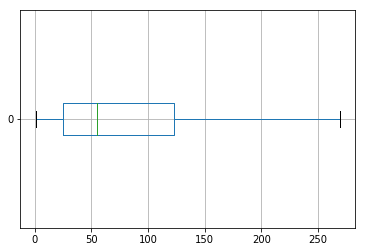

                   0
count  374492.000000
mean      138.024350
std       304.546214
min         1.000000
25%        25.035000
50%        54.692000
75%       122.760000
max      3598.678000


In [110]:
get_statistics(dts)

# join_dwell_reps
join_dwell_reps(new_df, dts, threshold=200000)

In [84]:
threshold = 2000 #비정상적으로 값이 큰 값들을 detect하기 위함인 것 같다
(dts // threshold).value_counts()

0.0    497211
1.0      2789
Name: Time, dtype: int64

In [85]:
def join_dwell_reps(df, dt, threshold=2000):
    # Calculate d_ti/threshold + 1
    # then add column to dataFrame
    
    dt //= threshold
    dt += 1   
    df['DwellReps'] = pd.Series(dt.astype(np.int64), index=dt.index)
    #return df

In [111]:
join_dwell_reps(new_df, dts, threshold = 2000)

In [112]:
new_df['DwellReps'].value_counts()

1    497211
2      2789
Name: DwellReps, dtype: int64

In [115]:
new_df.head()

,SessionId,ItemId,Time,ItemIdx,DwellReps
0,1,214536502,1.396868e+09,0,1
129,1,214536500,1.396868e+09,1,1
141,1,214536506,1.396868e+09,2,1
153,1,214577561,1.396868e+09,3,1
157,2,214662742,1.396879e+09,4,1


# augment
 df_aug = augment(new_df)

In [93]:
def augment(df):    
    col_names = list(df.columns.values)[:3]
    print(col_names)
    augmented = np.repeat(df.values, df['DwellReps'], axis=0) 
    print(augmented[0][:3])  
    augmented = pd.DataFrame(data=augmented[:,:3],
                             columns=col_names)
    
    dtype = {'SessionId': np.int64, 
             'ItemId': np.int64, 
             'Time': np.float32}
    
    for k, v in dtype.items():
        augmented[k] = augmented[k].astype(v)
                             
    
    return augmented

In [94]:
col_names = new_df.columns.values[:3]
col_names

array(['SessionId', 'ItemId', 'Time'], dtype=object)

In [100]:
new_df.values.shape

(500000, 5)

In [97]:
new_df['DwellReps'].shape

(500000,)

In [98]:
np.repeat(new_df.values, new_df['DwellReps'], axis=0).shape

(502789, 5)

In [113]:
df_aug  = augment(new_df)

['SessionId', 'ItemId', 'Time']
[1.00000000e+00 2.14536502e+08 1.39686787e+09]


In [114]:
df_aug.head()

,SessionId,ItemId,Time
0,1,214536502,1.396868e+09
1,1,214536500,1.396868e+09
2,1,214536506,1.396868e+09
3,1,214577561,1.396868e+09
4,2,214662742,1.396879e+09
